In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.func import vmap
import random
from typing import Callable
import torch
from torch.distributions import MultivariateNormal
import copy


In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
d = 2
n_opt = 5000
bs = 10000
lr  = 5e-3 
ncol = 6
ts   = torch.linspace(0, 1, ncol)

In [4]:
class NORMAL_BaseDistribution:
    def __init__(self, mean, cov):
        self.mean = mean
        self.covariance = cov
        self.distribution = MultivariateNormal(mean, cov)
    
    def sample(self, n=1):
        """
        Draws $n$ samples from the Gaussian distribution.   
        """
        return self.distribution.sample((n,))
    
    def log_prob(self, x):
        """
        Evaluates the log probability of given samples $x$ under the distribution. 
        """
        return self.distribution.log_prob(x)

class UNIFORM_BaseDistribution:
    def __init__(self, low, high):
        """
        Uniform distribution over a hyperrectangle defined by `low` and `high`.
        Both should be 1D tensors of the same shape.
        """
        self.low = low
        self.high = high
        self.distribution = torch.distributions.uniform.Uniform(low, high)
    
    def sample(self, n=1):
        """
        Draws `n` samples from the uniform distribution.
        """
        return self.distribution.sample((n,))
    
    def log_prob(self, x):
        """
        Evaluates the log probability of samples `x` under the uniform distribution.
        """
        return self.distribution.log_prob(x).sum(dim=-1)

class Interpolant:
    def alpha(self, t):
        return 1.0 - t
    
    def dotalpha(self, t):
        return -1.0
    
    def beta(self, t):
        return t
    
    def dotbeta(self, t):
        return 1.0
    
    def _single_xt(self, x0, x1, t):
        return self.alpha(t)*x0 + self.beta(t)*x1
    
    def _single_dtxt(self, x0, x1, t):
        return self.dotalpha(t)*x0 + self.dotbeta(t)*x1
    
    def xt(self, x0, x1, t):
        return vmap(self._single_xt, in_dims=(0, 0, 0))(x0,x1,t)
    
    def dtxt(self, x0, x1, t):
        return vmap(self._single_dtxt, in_dims=(0, 0, 0))(x0,x1,t)

class VelocityField(torch.nn.Module):
    # A neural network that takes x in R^d and t in [0, 1] and outputs a a value in R^d
    def __init__(self, d,  hidden_size = 256, activation=torch.nn.ReLU):
        super(VelocityField, self).__init__()
        ## the definition of our neural network, which is a composition
        ## of linear layers (weights + biases) and activation functions
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d + 1, hidden_size),
            activation(),
            torch.nn.Linear(hidden_size, hidden_size),
            activation(),
            torch.nn.Linear(hidden_size, hidden_size),
            activation(),
            torch.nn.Linear(hidden_size, d),
        )
    
    def _single_forward(self, x, t):  
        t = t.unsqueeze(-1)
        return self.net(torch.cat((x, t)))
    
    def forward(self, x, t):
        return vmap(self._single_forward, in_dims=(0,0), out_dims=(0))(x,t)


class ODEIntegrator:
    def __init__(self, b, interpolant, n_step):
        
        self.b           = b
        self.interpolant = interpolant
        self.n_step      = n_step
        self.ts          = torch.linspace(0.0,1.0, n_step + 1)
        self.dt          = self.ts[1] - self.ts[0]
    
    
    def step_forward(self, x: torch.tensor, t: torch.tensor):
        """Euler-Integration."""
        return x + self.b(x, t)*self.dt 
    
    def rollout(self, x_init):
        
        bs = x_init.shape[0]
        xs = torch.zeros((self.n_step, *x_init.shape))
        x = x_init
        for i,t in enumerate(self.ts[:-1]):
            t = t.repeat(len(x))
            x = self.step_forward(x,t)
            xs[i] = x
        return xs

In [5]:
def target(bs):
    x1 = torch.rand(bs) * 4 - 2
    x2_ = torch.rand(bs) - torch.randint(2, (bs,)) * 2
    x2 = x2_ + (torch.floor(x1) % 2)
    return (torch.cat([x1[:, None], x2[:, None]], 1) * 2)

def _single_loss(b, interpolant, x0, x1, t):
    """
    Interpolant loss function for a single datapoint of (x0, x1, t).
    """
    It   = interpolant._single_xt(  x0, x1, t)
    dtIt = interpolant._single_dtxt(x0, x1, t)
    
    bt          = b._single_forward(It, t)
    loss        = 0.5*torch.sum(bt**2) - torch.sum((dtIt) * bt)
    return loss

loss_fn = vmap(_single_loss, in_dims=(None, None, 0, 0, 0), out_dims=(0), randomness='different')

def teacher_train_step(b, interpolant, opt, N):
    x0s = base_normal.sample(N)
    x1s = target(N)
    ts  = torch.rand(N)
    
    loss_val = loss_fn(b, interpolant, x0s, x1s, ts).mean()
    
    loss_val.backward()
    opt.step()
    opt.zero_grad()
    
    res = {
            'loss': loss_val.detach(),
        }
    return res

def student_train_step(b, interpolant, opt, N, distill_pre, distill_post):
    x0s = distill_pre
    x1s = distill_post
    ts  = torch.rand(N)
    
    loss_val = loss_fn(b, interpolant, x0s, x1s, ts).mean()
    
    loss_val.backward()
    opt.step()
    opt.zero_grad()
    
    res = {
            'loss': loss_val.detach(),
        }
    return res

In [6]:
mean = torch.tensor([0.0, 0.0])  # \mu \in R^2
cov = torch.tensor([[1.0, 0.0], [0.0, 1.0]])  # \Sigma \in R^{2x2}

low = torch.tensor([-3.0, -3.0])  # Lower bound in each dimension
high = torch.tensor([3.0, 3.0])   # Upper bound in each dimension

base_normal = NORMAL_BaseDistribution(mean, cov)
base_uniform = UNIFORM_BaseDistribution(low, high)

In [7]:
interpolant = Interpolant()

b_teacher =  VelocityField(d, hidden_size=128)
b_student = copy.deepcopy(b_teacher)

opt_teacher = torch.optim.Adam(b_teacher.parameters(), lr=lr)
opt_student = torch.optim.Adam(b_student.parameters(), lr=lr)

pflow_teacher  = ODEIntegrator(b_teacher, interpolant, n_step = 100)
pflow_student  = ODEIntegrator(b_student, interpolant, n_step = 100)

In [8]:
teacher_losses = []

for i in range(n_opt):
    
    res = teacher_train_step(b_teacher, interpolant, opt_teacher, bs)
    loss = res['loss'].detach().numpy().mean()
    
    teacher_losses.append(loss)

In [9]:
x_distill_init = base_uniform.sample(10000)
x_distill_samples = pflow_teacher.rollout(x_distill_init)[-1].detach()

In [10]:
student_losses = []

for i in range(n_opt):
    
    res = student_train_step(b_student, interpolant, opt_student, bs, x_distill_init, x_distill_samples)
    loss = res['loss'].detach().numpy().mean()
    
    student_losses.append(loss)

In [11]:
x_eval = base_normal.sample(10000)
xfs_teacher = pflow_teacher.rollout(x_eval)
xfs_student = pflow_student.rollout(x_eval)

teacher_samples = xfs_teacher[-1].detach().numpy()
student_samples = xfs_student[-1].detach().numpy()

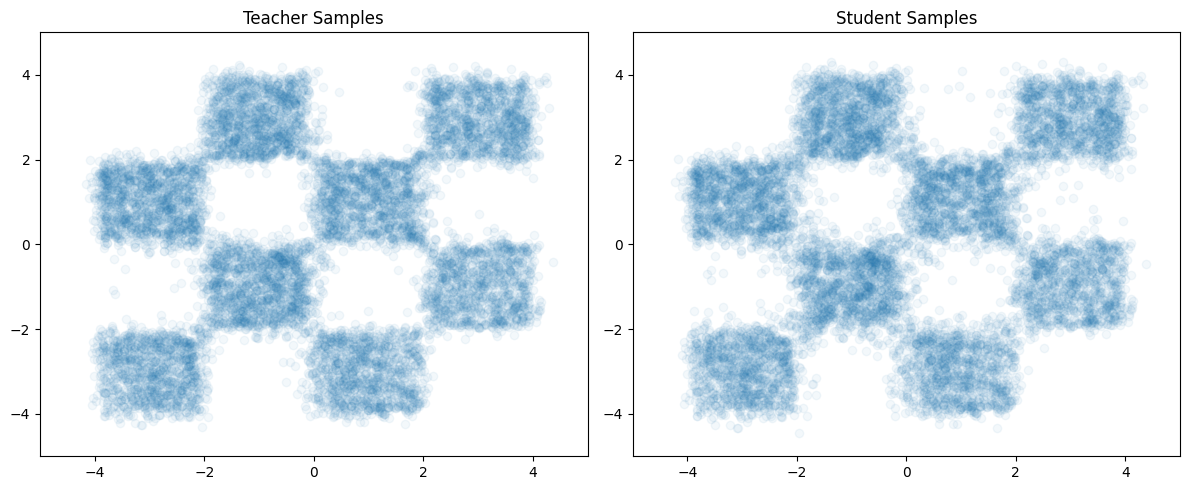

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

ax0.scatter(teacher_samples[:, 0], teacher_samples[:, 1], alpha=0.05)
ax0.set_title("Teacher Samples")
ax0.set_xlim(-5, 5), ax0.set_ylim(-5, 5)

ax1.scatter(student_samples[:, 0], student_samples[:, 1], alpha=0.05)
ax1.set_title("Student Samples")
ax1.set_xlim(-5, 5), ax1.set_ylim(-5, 5)

plt.tight_layout()
plt.show()

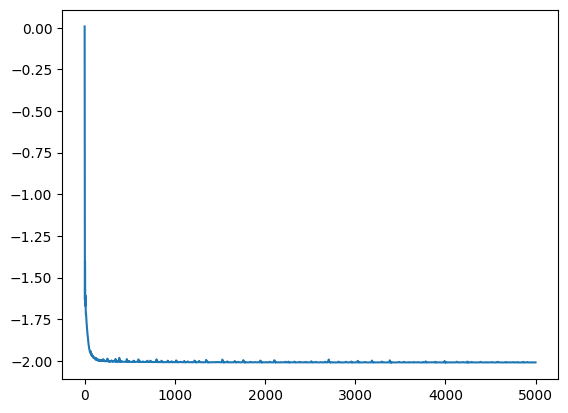

In [14]:
plt.plot(student_losses)

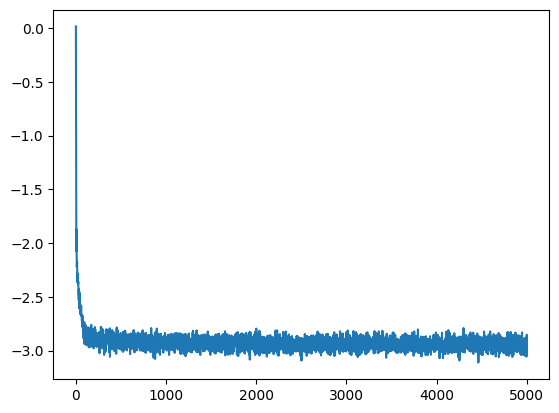

In [15]:
plt.plot(teacher_losses)

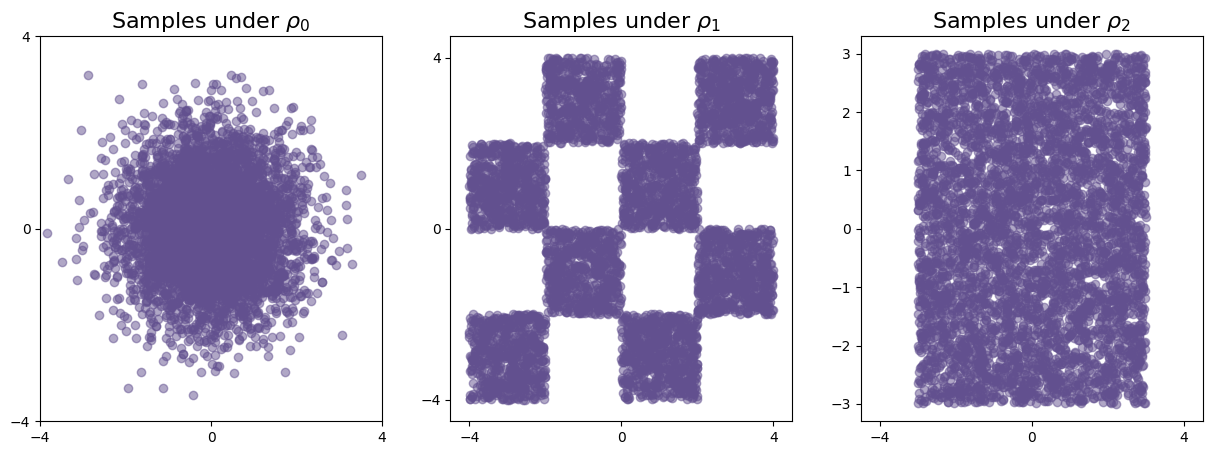

In [16]:
bs = 5000
c = '#62508f' # plot color

x0s = base_normal.sample(bs).detach().numpy()
x2s = base_uniform.sample(bs).detach().numpy()
x1s = target(bs).detach().numpy()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax0.scatter(x0s[:,0], x0s[:,1], alpha = 0.5, c = c)
ax0.set_xlim(-4,4), ax0.set_ylim(-4,4)
ax0.set_title(r"Samples under $\rho_0$", fontsize = 16)
ax0.set_xticks([-4,0,4]), ax0.set_yticks([-4,0,4])

ax1.scatter(x1s[:,0], x1s[:,1], alpha = 0.5, c = c)
ax1.set_xlim(-4.5,4.5), ax1.set_ylim(-4.5,4.5)
ax1.set_title(r"Samples under $\rho_1$", fontsize = 16)
ax1.set_xticks([-4,0,4]), ax1.set_yticks([-4,0,4]);

ax2.scatter(x2s[:,0], x2s[:,1], alpha = 0.5, c = c)
ax2.set_xlim(-4.5,4.5), ax1.set_ylim(-4.5,4.5)
ax2.set_title(r"Samples under $\rho_2$", fontsize = 16)
ax2.set_xticks([-4,0,4]), ax1.set_yticks([-4,0,4]);